# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pickle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np

# Define hyper-parameters
EPOCHS = 1000
BATCH_SIZE = 8192
learning_rate=0.8
keep_prob=0.8
want_to_train = False

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
validation_file = "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Define a Dataset structure and initialize the dataset
class DataSet:
    def __init__(self, dataset, batch_size=10000, shuffle=True):
        self.features = dataset['features']
        self.labels = dataset['labels']
        self.n_examples = len(self.features)
        self.idx = np.arange(0, self.n_examples)
        self.batch_size = batch_size
        self.start = 0
        self.end = self.start + self.batch_size
        self.not_finish = True
        self.debug_reset_times = 0
        if shuffle:
            np.random.shuffle(self.idx)

    def reset(self):
        self.start = 0
        self.end = self.start + self.batch_size
        self.not_finish = True
        np.random.shuffle(self.idx)
        self.debug_reset_times +=1
        #print("I have reset {} times".format(self.debug_reset_times))

    def move_pointer(self):
        self.start += self.batch_size
        self.end += self.batch_size

    def next_batch(self):
        '''
        Return a total of `num` random samples and labels.
        '''
        batch_idx = self.idx[self.start:self.end]
        batch_x = [self.features[i] for i in batch_idx]
        batch_y = [self.labels[i] for i in batch_idx]
        if self.end >= self.n_examples:
            self.not_finish = False
        self.move_pointer()
        #print("end pointer {}".format(self.end))
        return np.asarray(batch_x), np.asarray(batch_y)

train = DataSet(train,batch_size=BATCH_SIZE)
valid = DataSet(valid,batch_size=BATCH_SIZE)
test = DataSet(test,batch_size=BATCH_SIZE)

# define Tensorboard summary function for variables
# define 2 lists to store all summaries from training / (validation & test)
train_summaries = []
validation_summaries = []
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
    train_summaries.append(tf.summary.scalar('mean', mean))
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    train_summaries.append(tf.summary.scalar('stddev', stddev))
    train_summaries.append(tf.summary.scalar('max', tf.reduce_max(var)))
    train_summaries.append(tf.summary.scalar('min', tf.reduce_min(var)))
    train_summaries.append(tf.summary.histogram('histogram', var))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

16


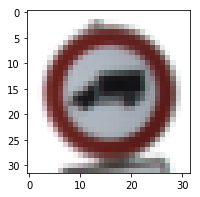

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
%matplotlib inline
# Visualizations will be shown in the notebook.
index = random.randint(0,n_train)
image = X_train[index]

plt.figure(figsize=(3,3))
plt.imshow(image)
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Batch Normalization function
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

### Model Architecture

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x, phase_train):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    with tf.name_scope("conv1"):
        # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
        x = batch_norm(x, 3, phase_train)
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        variable_summaries(conv1_W)
        variable_summaries(conv1_b)
        train_summaries.append(tf.summary.image("conv1_FM",[conv1[0,:,:,i][:,:,np.newaxis] for i in range(6)], 6))
        #batch_norm
        conv1 = batch_norm(conv1, 6, phase_train)

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1, name="act1")

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    with tf.name_scope("conv2"):
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        variable_summaries(conv2_W)
        variable_summaries(conv2_b)
        train_summaries.append(tf.summary.image("conv2_FM",[conv2[0,:,:,i][:,:,np.newaxis] for i in range(8)], 8))
        #batch Norm
        conv2 = batch_norm(conv2, 16, phase_train)

        
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    #conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    with tf.name_scope("conv3"):
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma))
        conv3_b = tf.Variable(tf.zeros(16))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
        variable_summaries(conv3_W)
        variable_summaries(conv3_b)
        train_summaries.append(tf.summary.image("conv3_FM",[conv3[0,:,:,i][:,:,np.newaxis] for i in range(8)], 8))
        #batch_norm
        conv3 = batch_norm(conv3, 16, phase_train)

        
    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 4x4x16.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 4x4x16. Output = 256.
    fc0   = flatten(conv3)
    fc0   = tf.nn.dropout(fc0,keep_prob)
    
    with tf.name_scope("full_connect_1"):
        # SOLUTION: Layer 3: Fully Connected. Input = 256. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        variable_summaries(fc1_W)
        variable_summaries(fc1_b)

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1,keep_prob)
    
    with tf.name_scope("full_connect_2"):
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        variable_summaries(fc2_W)
        variable_summaries(fc2_b)

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,keep_prob)
    with tf.name_scope("full_connect_3"):
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        variable_summaries(fc3_W)
        variable_summaries(fc3_b)
    
    return logits

# Traffic_signs consists of 32x32x3, grayscale images
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name="x_input")
y = tf.placeholder(tf.int32, (None))
y_ = tf.one_hot(y, 43, axis=-1)

phase_train = tf.placeholder(tf.bool, name='phase_train')

fc2= LeNet(x, phase_train)

# for output prediction probabilities


with tf.name_scope("training_loss_accuracy"):
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_))  
    correct_prediction = tf.equal(tf.argmax(fc2,axis=1), tf.cast(y,tf.int64))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    train_summaries.append(tf.summary.scalar("loss", loss_op))
    train_summaries.append(tf.summary.scalar("accuracy", accuracy_op))
with tf.name_scope("train"):
    opt = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
    train_op = opt.minimize(loss_op)   

with tf.name_scope("validation_loss_accuracy"):
    validation_summaries.append(tf.summary.scalar("loss_eval", loss_op))
    validation_summaries.append(tf.summary.scalar("accuracy_eval", accuracy_op))

print("Done.")

Done.


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
print("cell running")

def eval_data(dataset,merged_validation_summaries,step):
    loss, acc, summary_valid = sess.run([loss_op, accuracy_op, merged_validation_summaries], 
                                        feed_dict={x: dataset.features, y: dataset.labels, phase_train: False})    
    sum_writer.add_summary(summary_valid, step)
    return loss, acc, summary_valid

saver = tf.train.Saver()
if want_to_train:
    with tf.Session() as sess:
        merged_training_summaries = tf.summary.merge(train_summaries)
        merged_validation_summaries = tf.summary.merge(validation_summaries)
        sum_writer = tf.summary.FileWriter('./logs' + '/train/run3', sess.graph)

        sess.run(tf.global_variables_initializer(),{phase_train: True})

        # Train model
        step=0

        for i in range(EPOCHS):
            while train.not_finish:
                batch_x, batch_y = train.next_batch()
                loss, summary_train = sess.run([train_op, merged_training_summaries], 
                                               feed_dict={x: batch_x, y: batch_y, phase_train: True})

            sum_writer.add_summary(summary_train, step)
            train.reset()
            print("Training data rest {} times.".format(train.debug_reset_times))
            val_loss, val_acc, summary_valid = eval_data(valid,merged_validation_summaries,step)
            sum_writer.add_summary(summary_valid, step)
            step +=1

            print("EPOCH {} ...".format(i + 1))
            print("Validation loss = {:.3f}".format(val_loss))
            print("Validation accuracy = {:.3f}".format(val_acc))
            print()

        # Evaluate on the test data
        test_loss, test_acc, summary_valid = eval_data(test,merged_validation_summaries,step)
        sum_writer.add_summary(summary_valid, step)
        print("Test loss = {:.3f}".format(test_loss))
        print("Test accuracy = {:.3f}".format(test_acc))
        
        save_path = saver.save(sess, "./model/model.ckpt")
        print("Model saved in file: %s" % save_path)



cell running
Training data rest 1 times.
EPOCH 1 ...
Validation loss = 3.805
Validation accuracy = 0.028

Training data rest 2 times.
EPOCH 2 ...
Validation loss = 3.717
Validation accuracy = 0.053

Training data rest 3 times.
EPOCH 3 ...
Validation loss = 3.598
Validation accuracy = 0.083

Training data rest 4 times.
EPOCH 4 ...
Validation loss = 3.524
Validation accuracy = 0.093

Training data rest 5 times.
EPOCH 5 ...
Validation loss = 3.427
Validation accuracy = 0.124

Training data rest 6 times.
EPOCH 6 ...
Validation loss = 3.335
Validation accuracy = 0.156

Training data rest 7 times.
EPOCH 7 ...
Validation loss = 3.198
Validation accuracy = 0.183

Training data rest 8 times.
EPOCH 8 ...
Validation loss = 3.060
Validation accuracy = 0.225

Training data rest 9 times.
EPOCH 9 ...
Validation loss = 2.964
Validation accuracy = 0.247

Training data rest 10 times.
EPOCH 10 ...
Validation loss = 2.819
Validation accuracy = 0.266

Training data rest 11 times.
EPOCH 11 ...
Validation lo

Training data rest 88 times.
EPOCH 88 ...
Validation loss = 0.562
Validation accuracy = 0.829

Training data rest 89 times.
EPOCH 89 ...
Validation loss = 0.587
Validation accuracy = 0.824

Training data rest 90 times.
EPOCH 90 ...
Validation loss = 0.556
Validation accuracy = 0.828

Training data rest 91 times.
EPOCH 91 ...
Validation loss = 0.553
Validation accuracy = 0.830

Training data rest 92 times.
EPOCH 92 ...
Validation loss = 0.579
Validation accuracy = 0.829

Training data rest 93 times.
EPOCH 93 ...
Validation loss = 0.561
Validation accuracy = 0.831

Training data rest 94 times.
EPOCH 94 ...
Validation loss = 0.532
Validation accuracy = 0.839

Training data rest 95 times.
EPOCH 95 ...
Validation loss = 0.560
Validation accuracy = 0.828

Training data rest 96 times.
EPOCH 96 ...
Validation loss = 0.567
Validation accuracy = 0.832

Training data rest 97 times.
EPOCH 97 ...
Validation loss = 0.539
Validation accuracy = 0.837

Training data rest 98 times.
EPOCH 98 ...
Validati

Training data rest 173 times.
EPOCH 173 ...
Validation loss = 0.368
Validation accuracy = 0.895

Training data rest 174 times.
EPOCH 174 ...
Validation loss = 0.381
Validation accuracy = 0.883

Training data rest 175 times.
EPOCH 175 ...
Validation loss = 0.381
Validation accuracy = 0.891

Training data rest 176 times.
EPOCH 176 ...
Validation loss = 0.368
Validation accuracy = 0.897

Training data rest 177 times.
EPOCH 177 ...
Validation loss = 0.391
Validation accuracy = 0.890

Training data rest 178 times.
EPOCH 178 ...
Validation loss = 0.395
Validation accuracy = 0.888

Training data rest 179 times.
EPOCH 179 ...
Validation loss = 0.384
Validation accuracy = 0.891

Training data rest 180 times.
EPOCH 180 ...
Validation loss = 0.387
Validation accuracy = 0.887

Training data rest 181 times.
EPOCH 181 ...
Validation loss = 0.376
Validation accuracy = 0.890

Training data rest 182 times.
EPOCH 182 ...
Validation loss = 0.382
Validation accuracy = 0.897

Training data rest 183 times.


Training data rest 258 times.
EPOCH 258 ...
Validation loss = 0.318
Validation accuracy = 0.910

Training data rest 259 times.
EPOCH 259 ...
Validation loss = 0.358
Validation accuracy = 0.901

Training data rest 260 times.
EPOCH 260 ...
Validation loss = 0.332
Validation accuracy = 0.911

Training data rest 261 times.
EPOCH 261 ...
Validation loss = 0.335
Validation accuracy = 0.910

Training data rest 262 times.
EPOCH 262 ...
Validation loss = 0.347
Validation accuracy = 0.906

Training data rest 263 times.
EPOCH 263 ...
Validation loss = 0.328
Validation accuracy = 0.910

Training data rest 264 times.
EPOCH 264 ...
Validation loss = 0.325
Validation accuracy = 0.912

Training data rest 265 times.
EPOCH 265 ...
Validation loss = 0.320
Validation accuracy = 0.910

Training data rest 266 times.
EPOCH 266 ...
Validation loss = 0.319
Validation accuracy = 0.913

Training data rest 267 times.
EPOCH 267 ...
Validation loss = 0.342
Validation accuracy = 0.909

Training data rest 268 times.


Training data rest 343 times.
EPOCH 343 ...
Validation loss = 0.324
Validation accuracy = 0.919

Training data rest 344 times.
EPOCH 344 ...
Validation loss = 0.318
Validation accuracy = 0.918

Training data rest 345 times.
EPOCH 345 ...
Validation loss = 0.298
Validation accuracy = 0.926

Training data rest 346 times.
EPOCH 346 ...
Validation loss = 0.304
Validation accuracy = 0.922

Training data rest 347 times.
EPOCH 347 ...
Validation loss = 0.296
Validation accuracy = 0.923

Training data rest 348 times.
EPOCH 348 ...
Validation loss = 0.303
Validation accuracy = 0.919

Training data rest 349 times.
EPOCH 349 ...
Validation loss = 0.351
Validation accuracy = 0.915

Training data rest 350 times.
EPOCH 350 ...
Validation loss = 0.313
Validation accuracy = 0.917

Training data rest 351 times.
EPOCH 351 ...
Validation loss = 0.312
Validation accuracy = 0.917

Training data rest 352 times.
EPOCH 352 ...
Validation loss = 0.330
Validation accuracy = 0.918

Training data rest 353 times.


Training data rest 428 times.
EPOCH 428 ...
Validation loss = 0.312
Validation accuracy = 0.925

Training data rest 429 times.
EPOCH 429 ...
Validation loss = 0.285
Validation accuracy = 0.932

Training data rest 430 times.
EPOCH 430 ...
Validation loss = 0.292
Validation accuracy = 0.930

Training data rest 431 times.
EPOCH 431 ...
Validation loss = 0.284
Validation accuracy = 0.929

Training data rest 432 times.
EPOCH 432 ...
Validation loss = 0.308
Validation accuracy = 0.922

Training data rest 433 times.
EPOCH 433 ...
Validation loss = 0.315
Validation accuracy = 0.931

Training data rest 434 times.
EPOCH 434 ...
Validation loss = 0.314
Validation accuracy = 0.918

Training data rest 435 times.
EPOCH 435 ...
Validation loss = 0.297
Validation accuracy = 0.927

Training data rest 436 times.
EPOCH 436 ...
Validation loss = 0.308
Validation accuracy = 0.925

Training data rest 437 times.
EPOCH 437 ...
Validation loss = 0.301
Validation accuracy = 0.925

Training data rest 438 times.


Training data rest 513 times.
EPOCH 513 ...
Validation loss = 0.309
Validation accuracy = 0.927

Training data rest 514 times.
EPOCH 514 ...
Validation loss = 0.301
Validation accuracy = 0.927

Training data rest 515 times.
EPOCH 515 ...
Validation loss = 0.276
Validation accuracy = 0.930

Training data rest 516 times.
EPOCH 516 ...
Validation loss = 0.289
Validation accuracy = 0.931

Training data rest 517 times.
EPOCH 517 ...
Validation loss = 0.291
Validation accuracy = 0.929

Training data rest 518 times.
EPOCH 518 ...
Validation loss = 0.293
Validation accuracy = 0.927

Training data rest 519 times.
EPOCH 519 ...
Validation loss = 0.279
Validation accuracy = 0.934

Training data rest 520 times.
EPOCH 520 ...
Validation loss = 0.286
Validation accuracy = 0.931

Training data rest 521 times.
EPOCH 521 ...
Validation loss = 0.321
Validation accuracy = 0.925

Training data rest 522 times.
EPOCH 522 ...
Validation loss = 0.293
Validation accuracy = 0.929

Training data rest 523 times.


Training data rest 598 times.
EPOCH 598 ...
Validation loss = 0.277
Validation accuracy = 0.934

Training data rest 599 times.
EPOCH 599 ...
Validation loss = 0.278
Validation accuracy = 0.937

Training data rest 600 times.
EPOCH 600 ...
Validation loss = 0.292
Validation accuracy = 0.936

Training data rest 601 times.
EPOCH 601 ...
Validation loss = 0.301
Validation accuracy = 0.932

Training data rest 602 times.
EPOCH 602 ...
Validation loss = 0.294
Validation accuracy = 0.933

Training data rest 603 times.
EPOCH 603 ...
Validation loss = 0.323
Validation accuracy = 0.929

Training data rest 604 times.
EPOCH 604 ...
Validation loss = 0.297
Validation accuracy = 0.932

Training data rest 605 times.
EPOCH 605 ...
Validation loss = 0.322
Validation accuracy = 0.932

Training data rest 606 times.
EPOCH 606 ...
Validation loss = 0.302
Validation accuracy = 0.930

Training data rest 607 times.
EPOCH 607 ...
Validation loss = 0.312
Validation accuracy = 0.933

Training data rest 608 times.


Training data rest 683 times.
EPOCH 683 ...
Validation loss = 0.303
Validation accuracy = 0.936

Training data rest 684 times.
EPOCH 684 ...
Validation loss = 0.303
Validation accuracy = 0.935

Training data rest 685 times.
EPOCH 685 ...
Validation loss = 0.274
Validation accuracy = 0.933

Training data rest 686 times.
EPOCH 686 ...
Validation loss = 0.290
Validation accuracy = 0.937

Training data rest 687 times.
EPOCH 687 ...
Validation loss = 0.302
Validation accuracy = 0.937

Training data rest 688 times.
EPOCH 688 ...
Validation loss = 0.283
Validation accuracy = 0.939

Training data rest 689 times.
EPOCH 689 ...
Validation loss = 0.256
Validation accuracy = 0.937

Training data rest 690 times.
EPOCH 690 ...
Validation loss = 0.292
Validation accuracy = 0.936

Training data rest 691 times.
EPOCH 691 ...
Validation loss = 0.295
Validation accuracy = 0.936

Training data rest 692 times.
EPOCH 692 ...
Validation loss = 0.290
Validation accuracy = 0.934

Training data rest 693 times.


Training data rest 768 times.
EPOCH 768 ...
Validation loss = 0.306
Validation accuracy = 0.939

Training data rest 769 times.
EPOCH 769 ...
Validation loss = 0.342
Validation accuracy = 0.935

Training data rest 770 times.
EPOCH 770 ...
Validation loss = 0.279
Validation accuracy = 0.937

Training data rest 771 times.
EPOCH 771 ...
Validation loss = 0.322
Validation accuracy = 0.934

Training data rest 772 times.
EPOCH 772 ...
Validation loss = 0.294
Validation accuracy = 0.936

Training data rest 773 times.
EPOCH 773 ...
Validation loss = 0.308
Validation accuracy = 0.937

Training data rest 774 times.
EPOCH 774 ...
Validation loss = 0.287
Validation accuracy = 0.936

Training data rest 775 times.
EPOCH 775 ...
Validation loss = 0.272
Validation accuracy = 0.939

Training data rest 776 times.
EPOCH 776 ...
Validation loss = 0.282
Validation accuracy = 0.940

Training data rest 777 times.
EPOCH 777 ...
Validation loss = 0.290
Validation accuracy = 0.943

Training data rest 778 times.


Training data rest 853 times.
EPOCH 853 ...
Validation loss = 0.316
Validation accuracy = 0.934

Training data rest 854 times.
EPOCH 854 ...
Validation loss = 0.267
Validation accuracy = 0.944

Training data rest 855 times.
EPOCH 855 ...
Validation loss = 0.298
Validation accuracy = 0.938

Training data rest 856 times.
EPOCH 856 ...
Validation loss = 0.302
Validation accuracy = 0.938

Training data rest 857 times.
EPOCH 857 ...
Validation loss = 0.284
Validation accuracy = 0.938

Training data rest 858 times.
EPOCH 858 ...
Validation loss = 0.292
Validation accuracy = 0.939

Training data rest 859 times.
EPOCH 859 ...
Validation loss = 0.280
Validation accuracy = 0.939

Training data rest 860 times.
EPOCH 860 ...
Validation loss = 0.264
Validation accuracy = 0.938

Training data rest 861 times.
EPOCH 861 ...
Validation loss = 0.287
Validation accuracy = 0.937

Training data rest 862 times.
EPOCH 862 ...
Validation loss = 0.276
Validation accuracy = 0.939

Training data rest 863 times.


Training data rest 938 times.
EPOCH 938 ...
Validation loss = 0.276
Validation accuracy = 0.939

Training data rest 939 times.
EPOCH 939 ...
Validation loss = 0.286
Validation accuracy = 0.941

Training data rest 940 times.
EPOCH 940 ...
Validation loss = 0.303
Validation accuracy = 0.935

Training data rest 941 times.
EPOCH 941 ...
Validation loss = 0.270
Validation accuracy = 0.941

Training data rest 942 times.
EPOCH 942 ...
Validation loss = 0.276
Validation accuracy = 0.944

Training data rest 943 times.
EPOCH 943 ...
Validation loss = 0.299
Validation accuracy = 0.938

Training data rest 944 times.
EPOCH 944 ...
Validation loss = 0.309
Validation accuracy = 0.943

Training data rest 945 times.
EPOCH 945 ...
Validation loss = 0.309
Validation accuracy = 0.939

Training data rest 946 times.
EPOCH 946 ...
Validation loss = 0.291
Validation accuracy = 0.944

Training data rest 947 times.
EPOCH 947 ...
Validation loss = 0.303
Validation accuracy = 0.939

Training data rest 948 times.


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

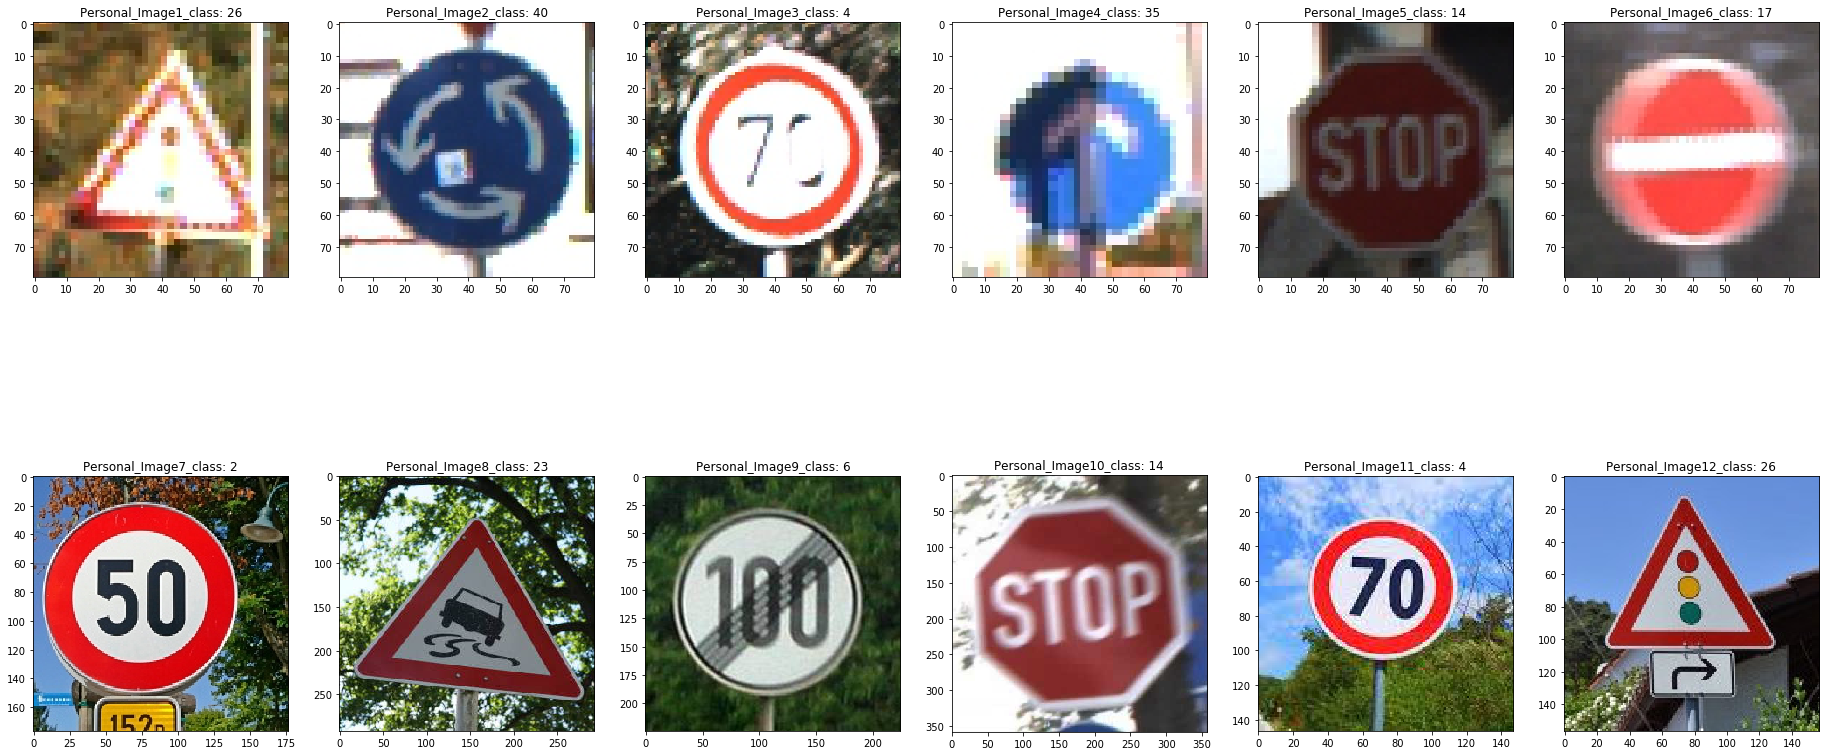

In [6]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from PIL import Image
my_imgs = []
img_counts = 12
my_labels = [26,40,4,35,14,17,2,23,6,14,4,26]
plt.figure(1, figsize=(32,32))
for i in range(img_counts):
    im = Image.open("./demo_pics/"+str(i+1)+".jpg")
    plt.subplot(4,6, i+1)
    plt.title('Personal_Image' + str(i+1)+"_class: "+str(my_labels[i]))
    plt.imshow(im)
    im.thumbnail((32, 32), Image.ANTIALIAS)
    im = np.asarray(im)
    my_imgs.append(im)

### Predict the Sign Type for Each Image

In [19]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
predictions = tf.argmax(fc2,axis=1)
softmax_act = tf.nn.softmax(fc2)
top5_act = tf.nn.top_k(softmax_act, k=5)

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, "./model/model.ckpt")
print("Model restored.")
my_imgs = np.array(my_imgs)
my_imgs = my_imgs.astype(np.float)
pred_new,top5_prob, acc_new, fc2_new, conv1_new = sess.run([predictions, top5_act, accuracy_op, fc2, "conv1/act1:0"],
                feed_dict={x: my_imgs, y: my_labels, phase_train: False})
print("")
print("the predicted classes:\n{}".format(pred_new))
print("Actual class should be:\n{}".format(my_labels))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Model restored.

the predicted classes:
[26 40  4 35 14 17  2 23  6 14  3 25]
Actual class should be:
[26, 40, 4, 35, 14, 17, 2, 23, 6, 14, 4, 26]


### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Accuracy for these images is: {} %".format(acc_new*100))

Accuracy for these images is: 83.33333134651184 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
#softmax_act = tf.nn.softmax(fc2)
#top5_prob = sess.run(tf.nn.top_k(softmax_act, k=5))
print(top5_prob)
print("Actual class should be:\n{}".format(my_labels))

TopKV2(values=array([[  9.99998808e-01,   6.92192089e-07,   4.31497057e-07,
          6.41800000e-08,   1.46565435e-08],
       [  9.99619842e-01,   3.80067824e-04,   6.60506956e-08,
          1.91607086e-09,   7.90609966e-10],
       [  9.99999881e-01,   9.58321564e-08,   2.95874170e-08,
          2.44568401e-08,   1.23732380e-09],
       [  9.99999642e-01,   3.05283208e-07,   7.84031340e-10,
          7.35486172e-10,   3.96830901e-10],
       [  9.99896169e-01,   5.93730983e-05,   1.88053782e-05,
          1.21305202e-05,   1.02408976e-05],
       [  1.00000000e+00,   1.97430207e-13,   5.31566220e-16,
          3.28441624e-17,   6.72244018e-18],
       [  9.99995232e-01,   4.59754756e-06,   1.37037929e-07,
          7.34646690e-08,   1.60690607e-08],
       [  1.00000000e+00,   8.54227855e-10,   5.10739895e-10,
          5.90200686e-13,   2.13553987e-13],
       [  9.99561369e-01,   3.97805299e-04,   3.88155458e-05,
          1.87778051e-06,   3.11875468e-08],
       [  9.99954224e-0

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


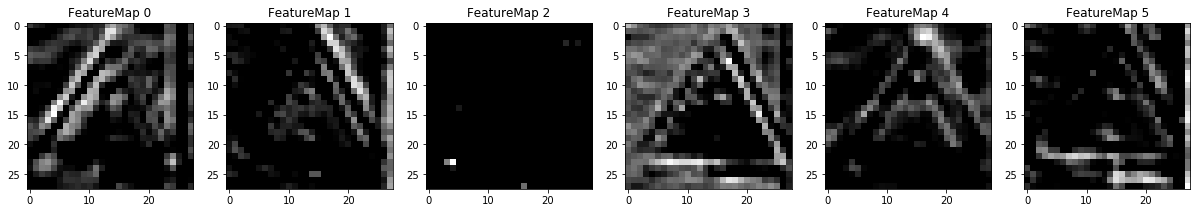

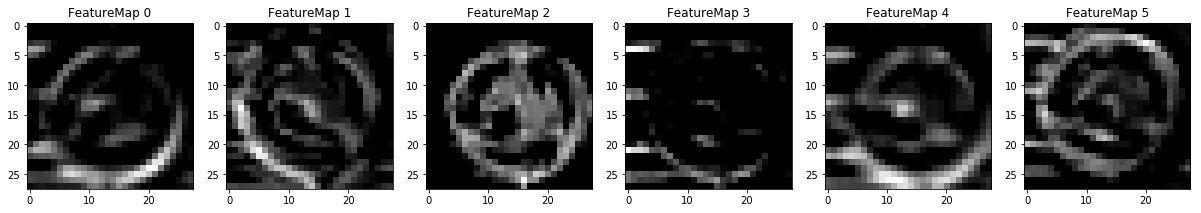

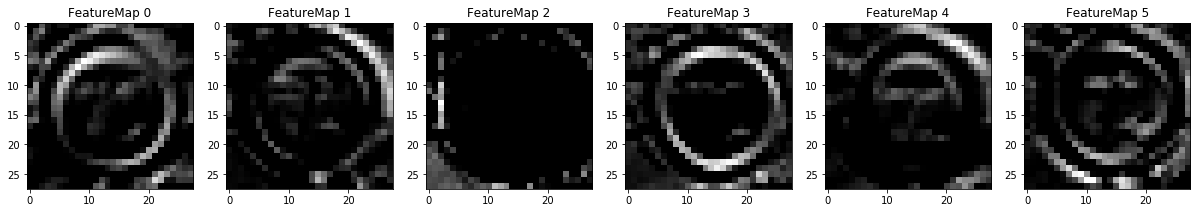

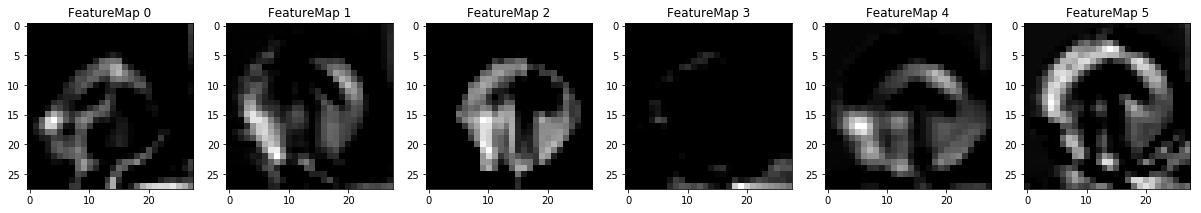

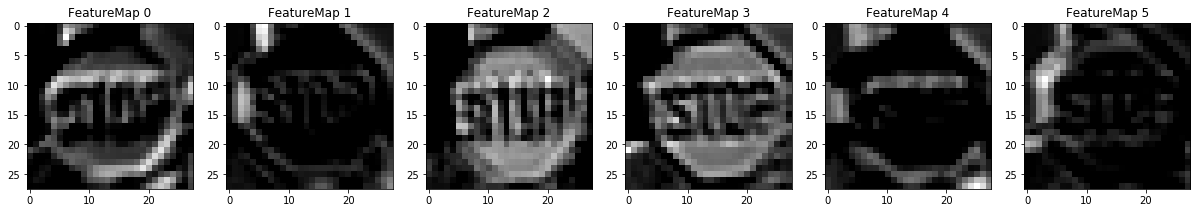

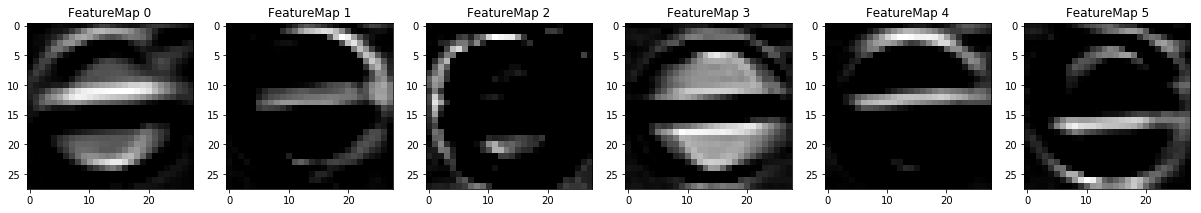

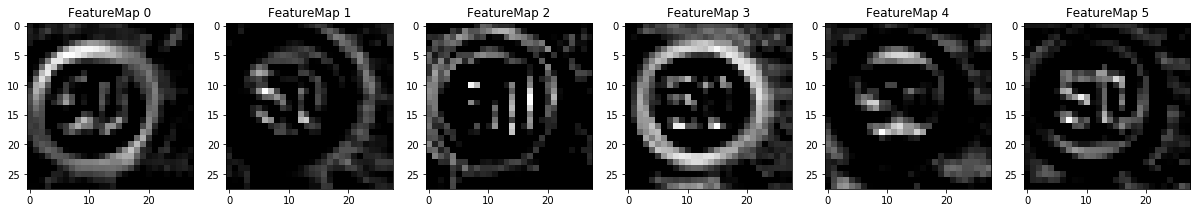

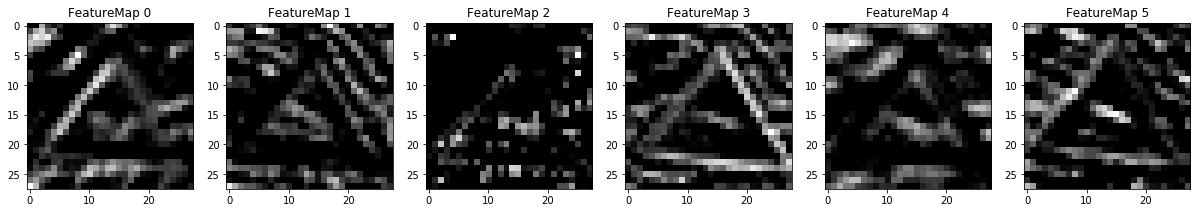

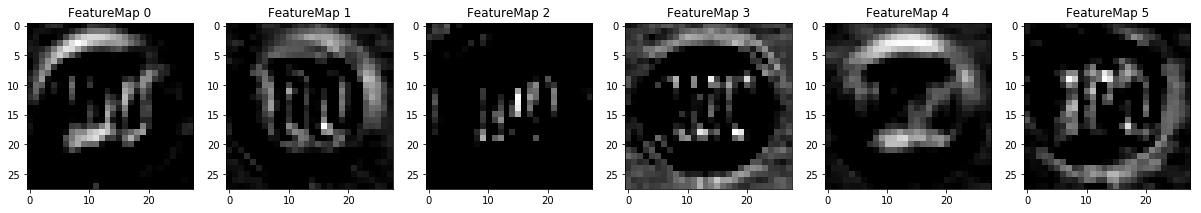

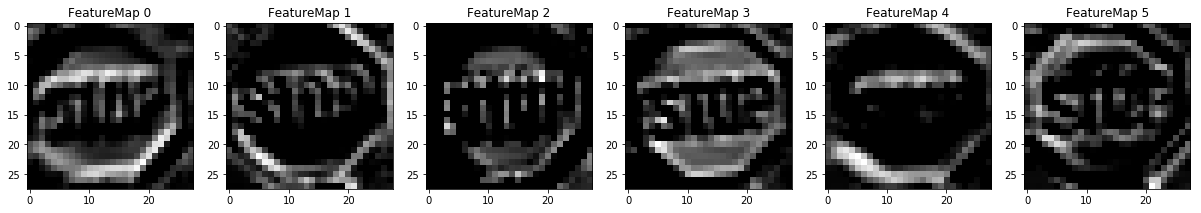

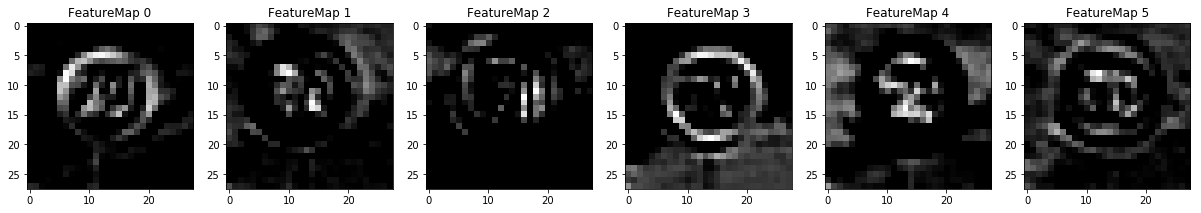

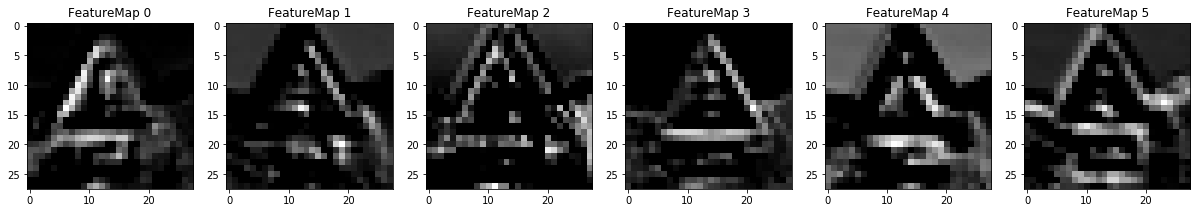

In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    activation = sess.run(tf_activation, feed_dict={x: image_input, phase_train: False})
    featuremaps = activation.shape[3]

    for sample in range(plt_num):
        plt.figure(sample+1, figsize=(28,28))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[sample,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[sample,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[sample,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[sample,:,:, featuremap], interpolation="nearest", cmap="gray")

outputFeatureMap(my_imgs, "conv1/act1:0", plt_num=img_counts)
